# Assessment of self-consumption value for typical household profile with PV generation and battery storage

This worksheet computes the self-consumption indicators for different PV and household demand profiles. Some profiles are historical measured profiles, some others are reconstructed from typical daily profiles. Due to the diversity of consumption patterns, the results can vary significantly from one household to the other. Therefore, a large number of profiles are simulated and the results are summirized in the final box plot for different EU countries.

For the sake of openness, the selected format is the open-source Ipython Notebook format, which allows to easily follow and check all calculations and hypotheses. The input data is public data and is also made available through csv files. The original ipynb file can be downloaded and allows further reuse/modification/adaptation of the notebook.

Sylvain Quoilin

Researcher at the European Commission (JRC).

E-mail: sylvain.quoilin@ec.europa.eu - Twitter: @squoilin

NB: The views expressed are purely those of the author and may not in any circumstances be regarded as stating an official position of the European Commission.

November 2015


## Loading Libraries and input data

All libraries are standard libraries that can be downloaded using pip or a package manager.

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import urllib
import pickle
import sys
sys.path.append('data')
from SC_functions import *
from time import sleep
%matplotlib inline

### Synthetic loads:

In [2]:
[TimeSeries_mean, HouseInfo] = pickle.load(open('pickle/TimeSeries_REMODECE.pickle','rb'))

### Historical Curve for 30 UK households

In [3]:
[TimeSeries_hist, HouseInfo_hist] = pickle.load(open('pickle/TimeSeries_UK.pickle','rb'))

### Generated log-noise for the 30 UK households

In [4]:
Noise = pickle.load(open('pickle/Noise.pickle','rb'))

### Modeled curve from a typical Belgian household

from http://hdl.handle.net/2268/147390. The data timestep is 15 min, the units are kWh.
All the data corresponds to a recent (>2005) belgian house (K45 standard) with day/night tariff. Three case are distinguished by successively adding electric domestic hot water heater and a heat pump
Time step is 15 min
The considered year is 2012 (without the last day).

UTC: time in UTC format
Appliance: Consumption for appliances and lightning
DHW: Appliances + lightning + DHW (electrical heater with storage)
HP: Appliances + Lightning + DWH + HP  
PV South: PV production with 35°C tilt angle, south orientation
PV West: PV production with 35°C tilt angle, west orientation
SLP: synthetic load profile for a residential househole without day/night tariff
SLP S22: synthetic load profile for a residential household with day/nigh tariff

In [5]:
[TimeSeries_be, HouseInfo_be] = pickle.load(open('pickle/TimeSeries_BE.pickle','rb'))
HouseInfo_hist = HouseInfo_hist.append(HouseInfo_be)
TimeSeries_hist = TimeSeries_hist.join(TimeSeries_be)

### Measurements on a French household

In [6]:
[TimeSeries_fr, HouseInfo_fr] = pickle.load(open('pickle/TimeSeries_FR.pickle','rb'))
HouseInfo_hist = HouseInfo_hist.append(HouseInfo_fr)
TimeSeries_hist = TimeSeries_hist.join(TimeSeries_fr)

### Measurements on Protugese households

Sustdata, extracted 20 housholds with measurements for one year (2011), 15 min

In [7]:
[TimeSeries_pt, HouseInfo_pt] = pickle.load(open('pickle/TimeSeries_PT_15min.pickle','rb'))
HouseInfo_hist = HouseInfo_hist.append(HouseInfo_pt)
TimeSeries_pt.index = TimeSeries_hist.index
TimeSeries_hist = TimeSeries_hist.join(TimeSeries_pt)

### Loading PV data

In [8]:
solar_data = pd.read_excel('data/meteonorm.xls')
idx = []
for key in solar_data.columns:
    idx.append(str(key.strip()))

solar_data.columns = idx

solar_data_15min = pd.DataFrame(columns = solar_data.columns,index=np.arange(35040))

for key in solar_data.columns:
    solar_data_15min[key] = pd.Series(data=np.interp(np.linspace(start=0,stop=8760,num=8760*4),range(8760),solar_data[key].values))

solar_data.columns

Index([u'TIME', u'Belgium', u'Germany', u'Italy', u'Spain', u'France', u'UK', u'Austria', u'Denmark', u'Hungary', u'Netherlands', u'Portugal', u'Romania', u'Italy-Palermo', u'Spain-Seville', u'Germany-Munich', u'Greece'], dtype='object')

### Plotting a sample of the data, historical values

Yearly PV generation: 6752.22210833 kWh
Yearly demand: 9646.03158333 kWh
Self Consumption: 2733.92577177 kWh
SSR = 0.283424924349
SCR = 0.404892749069


/usr/lib/python2.7/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


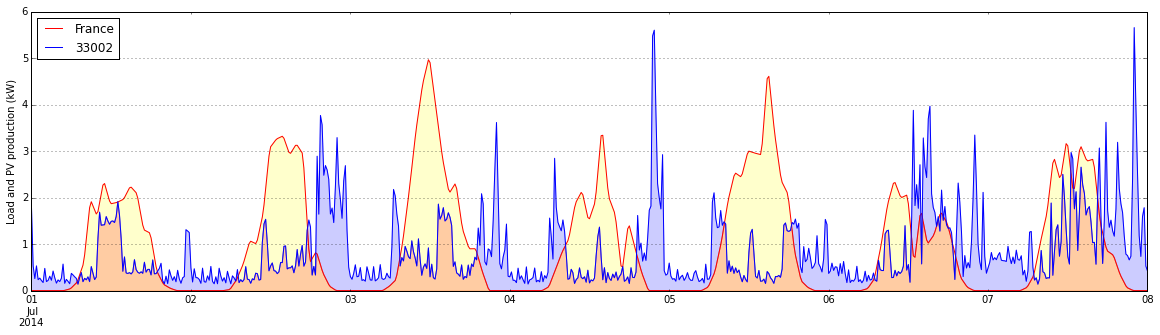

In [9]:
house_id = 33002
start = '07/01/2014 00:00:00'     # start of plotting interval
end = '07/08/2014 00:00:00'       # end of plotting interval
ratio_PV = 0.7                     # Ratio of yearly PV production to yearly demand

index_2014 = pd.DatetimeIndex(start='01/01/2014 00:00:00',end='31/12/2014 23:45:00',freq='15min')
interval = pd.DatetimeIndex(start=start,end=end,freq='15min')

demand = TimeSeries_hist[house_id]
demand.index = index_2014

PV = solar_data_15min[unicode(HouseInfo_hist['Country'][house_id])]
PV.index = index_2014

PV = PV * HouseInfo_hist['Annual Consumption'][house_id]/PV.sum()*4 * ratio_PV
demand = demand * HouseInfo_hist['Annual Consumption'][house_id]/demand.sum()*4

SelfConsumption = np.minimum(PV,demand)

plt.figure(figsize=(20,5))
PV[interval].plot(legend=True,color='red')
demand[interval].plot(legend=True,color='blue')
plt.ylabel('Load and PV production (kW)')

plt.fill_between(interval.values,PV[interval],0,color='yellow',alpha='0.2')
plt.fill_between(interval.values,SelfConsumption[interval],0,color='red',alpha='0.2')
plt.fill_between(interval.values,SelfConsumption[interval],demand[interval],color='blue',alpha='0.2')

self_consumption = np.minimum(PV.values,demand.values).sum()/4
SSR = self_consumption/demand.sum()*4
SCR = self_consumption/PV.sum()*4

print 'Yearly PV generation: ' + str(PV.sum()/4) + ' kWh'
print 'Yearly demand: ' + str(demand.sum()/4) + ' kWh'
print 'Self Consumption: ' + str(self_consumption) + ' kWh'
print 'SSR = ' + str(SSR)
print 'SCR = ' + str(SCR)

### Battery dispatch algorithm

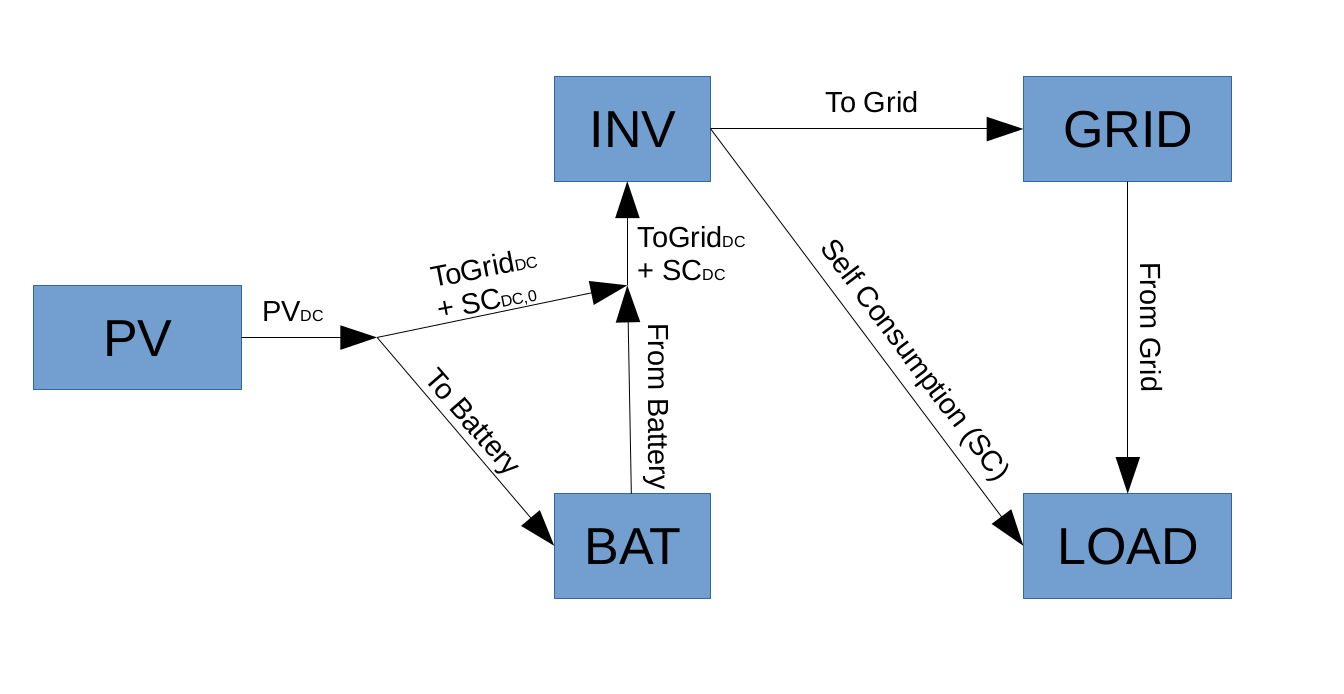

In [10]:
#import urllib
#urllib.urlretrieve ("http://squoilin.github.io/home_batteries/system.png", "system.png")
from IPython.display import Image
Image(filename='figures/system.png')

In [11]:
from SC_functions import battery_simulation

ratio_PV = 1    

param = {'BatteryCapacity':14,'BatteryEfficiency':0.92,'InverterEfficiency':0.96,'timestep':1./4,'MaxPower':2}

PV_DC = PV * HouseInfo_hist['Annual Consumption'][house_id]/PV.sum()*4 * ratio_PV/param['InverterEfficiency']

[BatteryGeneration,BatteryConsumption,LevelOfCharge,EnergyWithGrid] = battery_simulation(PV_DC,demand,param,print_analysis=True)

eta_inv = param['InverterEfficiency']
timestep = param['timestep']
PowerToGrid = pd.Series(np.maximum(-EnergyWithGrid,0)/timestep,index=index_2014)
PowerFromGrid = pd.Series(np.maximum(EnergyWithGrid,0)/timestep,index=index_2014)
demand_pd = pd.Series(demand,index=index_2014)




Total yearly consumption: 9646.03158333 kWh
Total PV production: 10047.949566 kWh
Self Consumption: 5361.44775712 kWh
Total fed to the grid: 4095.80269683 kWh
Total bought from the grid: 4284.58382621 kWh
Self consumption rate (SCR): 53.3586252789%
Self sufficiency rate (SSR): 55.5819013322%
Amount of energy provided by the battery: 2346.63764362 kWh
Average Charging/Discharging depth: 0.459224587792
Number of equivalent full cycles per year: 167.616974544
Total battery losses: 197.055447271 kWh
Total inverter losses: 394.035764748 kWh
Residue (check) :-0.392100000001kWh 



### Dispatch plot

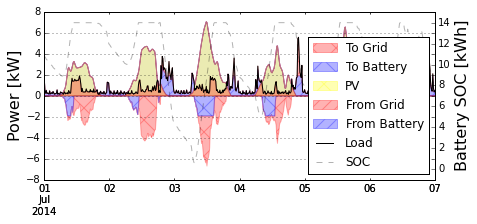

In [12]:
%matplotlib inline

alpha = '0.3'
PV_pd = pd.Series(PV_DC,index=index_2014)

pdrng = pd.DatetimeIndex(start='2014-07-01 00:00:00',end='2014-07-07 00:00:00',freq='15min')

SOC = pd.Series(LevelOfCharge-7,index=index_2014)

vec1 = pd.Series(- PowerToGrid - BatteryConsumption * eta_inv,index=index_2014)
vec2 = pd.Series(- BatteryConsumption * eta_inv,index=index_2014)
vec3 = pd.Series(PV_DC * eta_inv,index=index_2014)
vec4 = pd.Series((PV_DC+BatteryGeneration) * eta_inv,index=index_2014)
vec5 = pd.Series(PowerFromGrid + (PV_DC+BatteryGeneration) * eta_inv,index=index_2014)

vec_sc = pd.Series(np.minimum(PV_DC*eta_inv,demand),index=index_2014)

fig = plt.figure(figsize=(7,3))

leg_demand = ax = demand_pd[pdrng].plot(color='k',figsize=(7,3))
leg_SOC = plt.plot(pdrng,SOC[pdrng],color='k',alpha=0.3,linestyle='--')
leg1 = plt.fill_between(pdrng,vec1[pdrng],vec2[pdrng],color='r',alpha=alpha,hatch="x")
leg2 = plt.fill_between(pdrng,vec2[pdrng],0,color='b',alpha=alpha,hatch="x")
plt.fill_between(pdrng,0,vec3[pdrng],color='y',alpha=alpha)
plt.fill_between(pdrng,vec3[pdrng],vec4[pdrng],color='b',alpha=alpha,hatch="//")
plt.fill_between(pdrng,vec4[pdrng],vec5[pdrng],color='r',alpha=alpha,hatch="//")

plt.fill_between(pdrng,0,vec_sc[pdrng],color='r',alpha=alpha)

ax.set_ylabel('Power [kW]')
ax.yaxis.label.set_fontsize(16)

ax2 = fig.add_subplot(111, sharex=ax, frameon=False,label='aa')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylim(-1,15)
ax2.set_ylabel('Battery SOC [kWh]')
ax2.yaxis.label.set_fontsize(16)

# Legend:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
to_grid = mpatches.Patch(color='red',alpha=0.3,hatch='x',label='To Grid')
to_battery = mpatches.Patch(color='blue',alpha=0.3,hatch='x',label='To Battery')
sun = mpatches.Patch(color='yellow',alpha=0.3,hatch='x',label='PV')
from_grid = mpatches.Patch(color='red',alpha=0.3,hatch='//',label='From Grid')
from_battery = mpatches.Patch(color='blue',alpha=0.3,hatch='//',label='From Battery')
line_demand = mlines.Line2D([], [], color='black',label='Load')
line_SOC = mlines.Line2D([], [], color='black',alpha=0.3,label='SOC',linestyle='--')

plt.legend(handles=[to_grid,to_battery,sun,from_grid,from_battery,line_demand,line_SOC],loc=4)

### Compute the SSR surface for a sample household (historical values)

In [14]:
import yearly_simulation   # Importing the compiled version of the battery dispatch algorithm (much faster)

PVsum = PV.sum()/4 
DemandSum = demand.sum()/4/1000     
#ratios_PV = np.arange(0,5)
ratios_PV = [0, 0.25,0.5,1,2,5]
#ratios_battery = np.arange(0,5)
ratios_battery = np.arange(0,5,0.5)

SSR_hist = np.zeros([len(ratios_PV),len(ratios_battery)])
X = np.zeros([len(ratios_PV),len(ratios_battery)])
Y = np.zeros([len(ratios_PV),len(ratios_battery)])
param = {'BatteryCapacity':7,'BatteryEfficiency':0.92,'InverterEfficiency':0.96,'timestep':0.25}

for i in range(len(ratios_PV)):
    ratio_PV = ratios_PV[i]
    for j in range(len(ratios_battery)):
        ratio_battery = ratios_battery[j]
        param['BatteryCapacity'] = ratio_battery * DemandSum
        PV_DC = PV * HouseInfo_hist['Annual Consumption'][house_id]/PVsum * ratio_PV/param['InverterEfficiency']
        SSR_hist[i,j] = yearly_simulation.yearly_simulation(PV_DC.values,demand.values,param['timestep'],param['BatteryCapacity'], param['BatteryEfficiency'], param['InverterEfficiency'])
        #SSR_hist[i,j] = battery_simulation(PV_DC,demand,param,print_analysis=False,output_timeseries=False)
        X[i,j] = ratio_PV
        Y[i,j] = ratio_battery
        sys.stdout.write('.')

............................................................

### Compare computational speeds between the script and the compiled version

In [15]:
from timeit import Timer

param = {'BatteryCapacity':3,'BatteryEfficiency':0.92,'InverterEfficiency':0.96,'timestep':0.25}

t = Timer(lambda: battery_simulation(PV_DC,demand,param,print_analysis=False,output_timeseries=False))
print t.timeit(number=1)

t_compiled = Timer(lambda: yearly_simulation.yearly_simulation(PV_DC.values,demand.values,param['timestep'],param['BatteryCapacity'], param['BatteryEfficiency'], param['InverterEfficiency']))
print t_compiled.timeit(number=1)

2.78139686584
0.359970808029


### Check that the results are identical

In [16]:
# Checking values:

param = {'BatteryCapacity':2,'BatteryEfficiency':0.92,'InverterEfficiency':0.96,'timestep':0.25}

aa = yearly_simulation.yearly_simulation(PV_DC.values,demand.values,param['timestep'],param['BatteryCapacity'], param['BatteryEfficiency'], param['InverterEfficiency'])
bb = battery_simulation(PV_DC,demand,param,print_analysis=False,output_timeseries=False)

print aa
print bb


52.338157158
52.338157158


### Plotting a sample of the data, synthetic values

Target size is a multiple of input vector size. Repeating values
Yearly PV generation: 7009.6 kWh
Yearly demand: 7009.6 kWh
Self Consumption: 3196.3310165 kWh
SSR = 0.455993354329
SCR = 0.455993354329


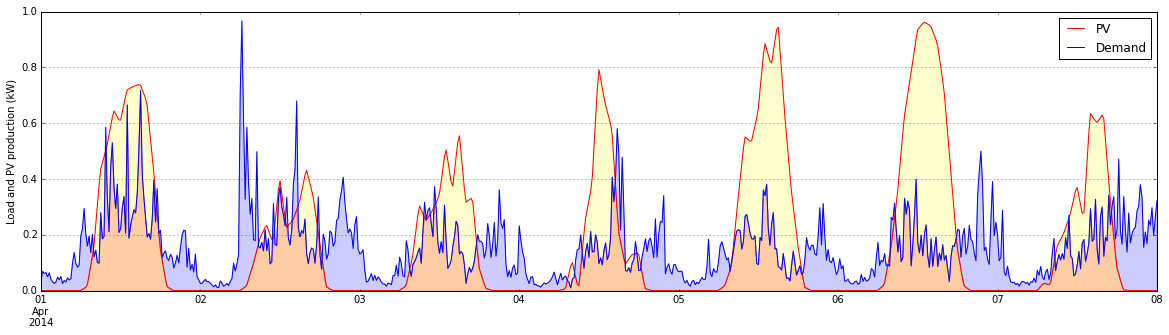

In [18]:
%matplotlib inline

house_id = 2000101
noise_idx = np.random.randint(0,30)
start = '04/01/2014 00:00:00'     # start of plotting interval
end = '04/08/2014 00:00:00'       # end of plotting interval
ratio_PV = 1                      # Ratio of yearly PV production to yearly demand

index_2014 = pd.DatetimeIndex(start='01/01/2014 00:00:00',end='31/12/2014 23:45:00',freq='15min')
interval = pd.DatetimeIndex(start=start,end=end,freq='15min')

demand = TimeSeries_mean[house_id]
demand = pd.Series(index=index_2014,data=scale_vector(demand.values,35040))

PV = solar_data_15min[unicode(HouseInfo['Country'][house_id])]
PV.index = index_2014

noise = Noise.iloc[:,noise_idx]
noise.index = index_2014

PV = PV * HouseInfo['Annual Consumption'][house_id]/PV.sum() * ratio_PV
demand = demand*np.exp(noise)
demand = demand * HouseInfo['Annual Consumption'][house_id]/demand.sum()

SelfConsumption = np.minimum(PV,demand)

plt.figure(figsize=(20,5))
PV[interval].plot(legend=True,color='red',label='PV')
demand[interval].plot(legend=True,color='blue',label='Demand')
plt.ylabel('Load and PV production (kW)')

plt.fill_between(interval.values,PV[interval],0,color='yellow',alpha='0.2')
plt.fill_between(interval.values,SelfConsumption[interval],0,color='red',alpha='0.2')
plt.fill_between(interval.values,SelfConsumption[interval],demand[interval],color='blue',alpha='0.2')

self_consumption = np.minimum(PV.values,demand.values).sum()
SSR = self_consumption/demand.sum()
SCR = self_consumption/PV.sum()

print 'Yearly PV generation: ' + str(PV.sum()) + ' kWh'
print 'Yearly demand: ' + str(demand.sum()) + ' kWh'
print 'Self Consumption: ' + str(self_consumption) + ' kWh'
print 'SSR = ' + str(SSR)
print 'SCR = ' + str(SCR)

### Loop over all households to generate synthetic load profiles:

In [19]:
Nhouses = TimeSeries_mean.shape[1]

index_2014 = pd.DatetimeIndex(start='01/01/2014 00:00:00',end='31/12/2014 23:45:00',freq='15min')
TimeSeries_WithNoise = pd.DataFrame(index=index_2014)

for k in range(Nhouses):
    # progress bar:
    ratio = k*100/Nhouses+1
    sys.stdout.write('\r')
    sys.stdout.write("[%-100s] %d/%d" % ('='*ratio, k+1, Nhouses))
    sys.stdout.flush()
    
    house_id = TimeSeries_mean.columns[k]
    #print str(house_id) + HouseInfo['Country'][house_id]
    noise_idx = np.random.randint(0,30)

    noise = Noise.iloc[:,noise_idx]
    noise.index = index_2014
    
    demand = pd.Series(index=index_2014,data=scale_vector(TimeSeries_mean[house_id].values,35040,silent=True))
    demand = demand * np.exp(noise)
    demand = demand * HouseInfo['Annual Consumption'][house_id]/(demand.sum()/4)
    TimeSeries_WithNoise[house_id] = demand
    
TimeSeries_WithNoise.to_pickle('outputs/TimeSeries_WithNoise.pickle')
#TimeSeries_WithNoise.to_excel('Time series.xlsx')
HouseInfo.to_excel('outputs/Households.xls')

[====================================================================================================] 894/894

### Loop over all household profiles to compute SSR (time consuming!):

In [ ]:
import yearly_simulation

TimeSeries = pickle.load(open('pickle/TimeSeries_WithNoise_ok.pickle','rb'))
Nhouses = TimeSeries.shape[1]

ratios_PV = [0.25,0.5,1,2,5]
ratios_battery = np.arange(0,5,0.5)

SSRs = np.zeros([len(ratios_PV),len(ratios_battery),Nhouses])
N_tot = len(ratios_PV)*len(ratios_battery)*Nhouses

param = {'BatteryCapacity':0,'BatteryEfficiency':0.92,'InverterEfficiency':0.96,'timestep':0.25}
index_2014 = pd.DatetimeIndex(start='01/01/2014 00:00:00',end='31/12/2014 23:45:00',freq='15min')

for k in range(Nhouses):
    # progress bar:
    n = (k+1) * len(ratios_PV)*len(ratios_battery)
    ratio = n/N_tot * 100 + 1
    sys.stdout.write('\r')
    sys.stdout.write("[%-100s] %d/%d" % ('='*ratio, n, N_tot))
    sys.stdout.flush()
    
    house_id = TimeSeries.columns[k]
    #print str(house_id) + HouseInfo['Country'][house_id]

    demand = TimeSeries[house_id]
    
    try:
        PV = solar_data_15min[unicode(HouseInfo['Country'][house_id])]
    except: 
        PV = solar_data_15min[u'Greece']
    PV.index = index_2014
    
    # PV and demand profiles have been set for this household, computing SSR:
    PVsum = PV.sum()/4
    DemandSum = demand.sum()/4    

    for i in range(len(ratios_PV)):
        ratio_PV = ratios_PV[i]
        for j in range(len(ratios_battery)):
            ratio_battery = ratios_battery[j]
            param['BatteryCapacity'] = ratio_battery * DemandSum/1000
            PV_DC = PV /PVsum * DemandSum * ratio_PV/param['InverterEfficiency']
            SSRs[i,j,k] = yearly_simulation.yearly_simulation(PV_DC.values,demand.values,param['timestep'],param['BatteryCapacity'], param['BatteryEfficiency'], param['InverterEfficiency'])
            #SSRs[i,j,k] = battery_simulation(PV_DC,demand,param,print_analysis=False,output_timeseries=False)
            
            

### Loop over all historical household profiles to compute SSR (time consuming!):

In [ ]:
import yearly_simulation

Nhouses = TimeSeries_hist.shape[1]

ratios_PV = [0.25,0.5,1,2,5]
ratios_battery = np.arange(0,5,0.5)

SSRs_hist = np.zeros([len(ratios_PV),len(ratios_battery),Nhouses])
N_tot = len(ratios_PV)*len(ratios_battery)*Nhouses

param = {'BatteryCapacity':0,'BatteryEfficiency':0.92,'InverterEfficiency':0.96,'timestep':0.25}
index_2014 = pd.DatetimeIndex(start='01/01/2014 00:00:00',end='31/12/2014 23:45:00',freq='15min')

for k in range(Nhouses):
    # progress bar:
    n = (k+1) * len(ratios_PV)*len(ratios_battery)
    ratio = n/N_tot * 100 + 1
    sys.stdout.write('\r')
    sys.stdout.write("[%-100s] %d/%d" % ('='*ratio, n, N_tot))
    sys.stdout.flush()
    
    house_id = TimeSeries_hist.columns[k]
    #print str(house_id) + HouseInfo['Country'][house_id]

    demand = TimeSeries_hist[house_id]
    
    try:
        PV = solar_data_15min[unicode(HouseInfo_hist['Country'][house_id])]
    except: 
        PV = solar_data_15min[u'Greece']
    PV.index = index_2014
    
    # PV and demand profiles have been set for this household, computing SSR:
    PVsum = PV.sum()/4
    DemandSum = demand.sum()/4    

    for i in range(len(ratios_PV)):
        ratio_PV = ratios_PV[i]
        for j in range(len(ratios_battery)):
            ratio_battery = ratios_battery[j]
            param['BatteryCapacity'] = ratio_battery * DemandSum/1000
            PV_DC = PV /PVsum * DemandSum * ratio_PV/param['InverterEfficiency']
            SSRs_hist[i,j,k] = yearly_simulation.yearly_simulation(PV_DC.values,demand.values,param['timestep'],param['BatteryCapacity'], param['BatteryEfficiency'], param['InverterEfficiency'])
            

### Save results

In [ ]:
pickle.dump(SSRs,open('outputs/SSR.pickle','w'))

In [24]:
pickle.dump(SSRs_hist,open('outputs/SSR_hist.pickle','w'))

### Load results and select data

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import urllib
import pickle
import sys
from SC_functions import *
from time import sleep
%matplotlib inline

SSR_dict = {}
SSR0_dict = {}

SSRs_temp = pickle.load(open('pickle/SSR_ok.pickle','rb'))
SSRs_hist_temp = pickle.load(open('pickle/SSR_hist.pickle','rb'))

# original number of households in the SSR data
N = SSRs_temp.shape[2]
N_hist = SSRs_hist_temp.shape[2]

# x and y axes:
ratios_PV = [0.25,0.5,1,2,5]
ratios_battery = np.arange(0,5,0.5)

# Adding the trivial case ratio_PV = 0:
SSRs = np.zeros([len(ratios_PV)+1, len(ratios_battery),N])
SSRs[1:len(ratios_PV)+1,:,:] = SSRs_temp
SSRs_hist = np.zeros([len(ratios_PV)+1, len(ratios_battery),N_hist])
SSRs_hist[1:len(ratios_PV)+1,:,:] = SSRs_hist_temp
ratios_PV = [0] + ratios_PV

# Defining grid:
PV,BAT = np.meshgrid(ratios_PV,ratios_battery)

# Find the households with nan values:
notdefined = np.unique(np.where(np.isnan(SSRs))[2])

# Find the households whose consumption is inferior to 1000 kWh/year:
TooSmall = [k for k in range(N) if HouseInfo['Annual Consumption'].iloc[k] < 1000]

# selected indexes:
#countries = [u'Denmark', u'Greece', u'Italy', u'Portugal', u'France',u'Romania', 'Hungary', 'Spain']
countries = [u'Denmark', u'Greece', u'Italy', u'Portugal', u'France',u'Romania']
idx = {}
idx['all'] = [k for k in range(N) if k not in notdefined]
for country in countries:
    idx[country] = [k for k in range(N) if k not in notdefined and HouseInfo['Country'].iloc[k]==country]

countries = [u'Denmark', u'Greece', u'Italy', u'Portugal', u'France',u'Romania']
idx = {}
idx['all'] = [k for k in range(N) if k not in notdefined and k not in TooSmall]
for country in countries:
    idx[country] = [k for k in range(N) if k not in notdefined and k not in TooSmall and HouseInfo['Country'].iloc[k]==country]    
    
SSR_dict['all'] = SSRs[:,:,idx['all']].mean(2).transpose()
for country in countries:
    SSR_dict[country] = SSRs[:,:,idx[country]].mean(2).transpose()
    SSR0_dict[country] = SSRs[3,0,idx[country]]

idx_hist = {}
#idx_hist['France Historical'] = [k for k in range(N_hist) if HouseInfo_hist['Country'].iloc[k]=='France']
idx_hist['UK Historical'] = [k for k in range(N_hist) if HouseInfo_hist['Country'].iloc[k]=='UK']
idx_hist['Portugal Historical'] = [k for k in range(N_hist) if HouseInfo_hist['Country'].iloc[k]=='Portugal']
for key in idx_hist:
    SSR_dict[key] = SSRs_hist[:,:,idx_hist[key]].mean(2).transpose()


#SSR = SSRs[:,:,100].transpose()
SSR = SSR_dict['all']

# Find the household whose SSR is closest to the selected one:
best = 1E10
for k in range(N):
    if np.sqrt(((SSRs[:,:,k] - SSR.transpose()) ** 2).mean()) < best:
        best = np.sqrt(((SSRs[:,:,k] - SSR.transpose()) ** 2).mean())
        pos_best = k
        
print 'Selected SSR data:'
print pd.DataFrame(SSR)

print '\nThe closest household to the selected one in terms of SSR is household n° ' + str(pos_best) + ', with house_id ' + str(HouseInfo.index[pos_best]) + ':'
print pd.DataFrame(SSRs[:,:,pos_best].transpose())



Selected SSR data:
   0          1          2          3          4          5
0  0  18.257450  25.996862  32.949234  38.600550  44.038767
1  0  23.753202  37.764908  47.797922  54.522579  60.282857
2  0  24.369583  43.494081  58.577620  67.503571  74.091284
3  0  24.463891  45.590362  65.813763  76.640799  83.770958
4  0  24.502052  46.358592  69.899189  81.968111  89.402484
5  0  24.532634  46.759240  72.087176  85.002944  92.476733
6  0  24.560053  47.010884  73.368980  86.874937  94.236715
7  0  24.585880  47.188028  74.236312  88.137502  95.330133
8  0  24.610887  47.325810  74.882601  89.052641  96.068367
9  0  24.635559  47.439753  75.392616  89.742634  96.597949

The closest household to the selected one in terms of SSR is household n° 796, with house_id 2003065:
   0          1          2          3          4          5
0  0  17.703214  25.314954  32.603366  38.653994  44.516001
1  0  24.272015  38.434935  48.376400  55.066101  60.789940
2  0  24.462543  45.000707  60.077074 

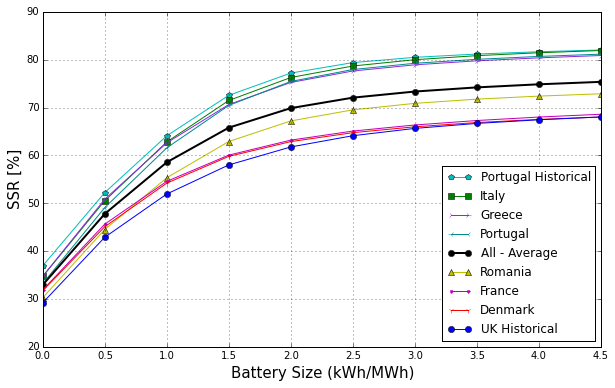

In [14]:
SSR_pd = pd.DataFrame(columns=SSR_dict.keys(),index=ratios_battery)
for key in SSR_dict:
    SSR_pd[key] = SSR_dict[key][:,3]
#SSR_pd.plot(figsize=[20,10],fontsize=20,sort_columns=True)


import matplotlib.pyplot as plt
fig = plt.figure(figsize=[10,6])
plt.plot(ratios_battery,SSR_dict['Portugal Historical'][:,3], marker='p', color='c', label='Portugal Historical')
plt.plot(ratios_battery,SSR_dict['Italy'][:,3], marker='s', color='g', label='Italy')
plt.plot(ratios_battery,SSR_dict['Greece'][:,3], marker='4', color='blueviolet', label='Greece')
plt.plot(ratios_battery,SSR_dict['Portugal'][:,3], marker='3', color='darkcyan', label='Portugal')
plt.plot(ratios_battery,SSR_dict['all'][:,3], marker='o', color='k', label='All - Average', linewidth=2)
plt.plot(ratios_battery,SSR_dict['Romania'][:,3], marker='^', color='y', label='Romania')
plt.plot(ratios_battery,SSR_dict['France'][:,3], marker='.', color='m', label='France')
plt.plot(ratios_battery,SSR_dict['Denmark'][:,3], marker='1', color='r', label='Denmark')
plt.plot(ratios_battery,SSR_dict['UK Historical'][:,3], marker='o', color='b', label='UK Historical')
plt.xlabel('Battery Size (kWh/MWh)',fontsize=15)
plt.ylabel('SSR [%]',fontsize=15)
plt.legend(loc=4,fontsize=12)
plt.grid()

### Box plot

Using matplotlib backend: TkAgg


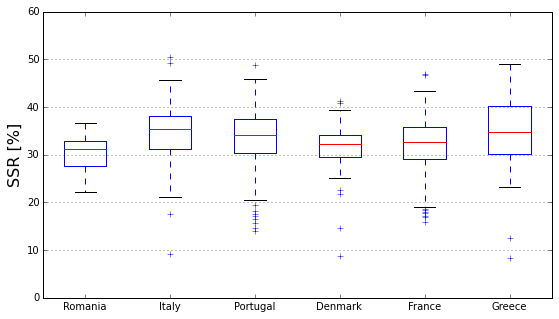

In [15]:
%matplotlib
fig = plt.figure(figsize=(9,5))
plt.boxplot(SSR0_dict.values(),labels=SSR0_dict.keys())
plt.ylabel('SSR [%]')
#plt.title('Box plot of the Self-sufficiency rate for each country (PV/demand ratio: 1)')
ax = plt.axes()    
ax.yaxis.label.set_fontsize(16)
ax.yaxis.grid() # horizontal lines
ax.xaxis.label.set_fontsize(16)

### Plotting SSR surface

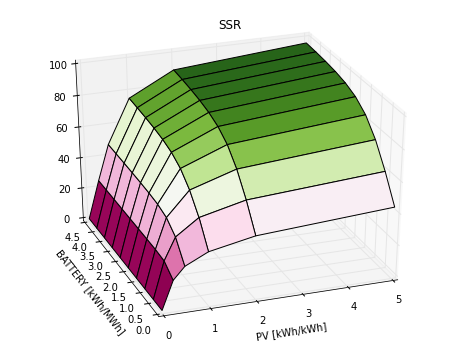

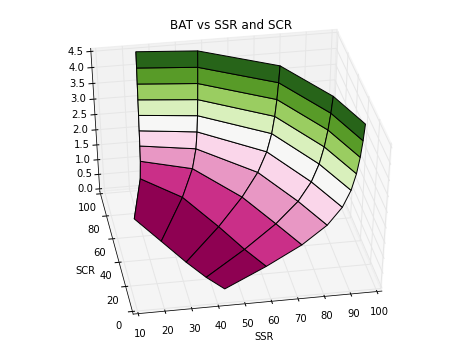

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import interactive
interactive(True)
from pylab import colormaps
cmaps = colormaps()

%matplotlib inline

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(30,-110)
#ax.plot_surface(np.log(PV+1),np.log(BAT+1),SSR,cmap=cmaps[32],rstride=1, cstride=1)
ax.plot_surface(PV,BAT,SSR,cmap=cmaps[32],rstride=1, cstride=1)
ax.set_xlabel('PV [kWh/kWh]')
ax.set_ylabel('BATTERY [kWh/MWh]')
plt.title('SSR')


SCR = SSR/PV
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(40,260)
#ax.plot_surface(np.log(PV+1),np.log(BAT+1),SSR,cmap=cmaps[32],rstride=1, cstride=1)
ax.plot_surface(SSR,SCR,BAT,cmap=cmaps[32],rstride=1, cstride=1)
plt.title('BAT vs SSR and SCR')
ax.set_xlabel('SSR')
ax.set_ylabel('SCR')


### Using the closest household to compute high resolution SSR data:

In [17]:
import yearly_simulation   # Importing the compiled version of the battery dispatch algorithm (much faster)

# House profile that is the closes to the average in terms of SSR:
house_id = 2003065

# Closest house profile to the danish average:
#house_id = 2000056

# Closest house profile to the Portugese average:
#house_id = 2000464

TimeSeries_noise = pickle.load(open('pickle/TimeSeries_WithNoise_ok.pickle','rb'))
demand = TimeSeries_noise[house_id]

index_2014 = pd.DatetimeIndex(start='01/01/2014 00:00:00',end='31/12/2014 23:45:00',freq='15min')
demand = pd.Series(index=index_2014,data=scale_vector(demand.values,35040,silent=True))

try:
    PV = solar_data_15min[unicode(HouseInfo['Country'][house_id])]
except: 
    PV = solar_data_15min[u'Greece']
PV.index = index_2014

PVsum = PV.sum()/4 
DemandSum = demand.sum()/4/1000     

ratios_PV = np.arange(0,5.5,0.2)
ratios_battery = np.arange(0,6,0.25)

SSR_hr = np.zeros([len(ratios_PV),len(ratios_battery)])
PV_hr = np.zeros([len(ratios_PV),len(ratios_battery)])
BAT_hr = np.zeros([len(ratios_PV),len(ratios_battery)])
param = {'BatteryCapacity':7,'BatteryEfficiency':0.92,'InverterEfficiency':0.96,'timestep':0.25}

for i in range(len(ratios_PV)):
    ratio_PV = ratios_PV[i]
    for j in range(len(ratios_battery)):
        ratio_battery = ratios_battery[j]
        param['BatteryCapacity'] = ratio_battery * DemandSum
        PV_DC = PV * HouseInfo['Annual Consumption'][house_id]/PVsum * ratio_PV/param['InverterEfficiency']
        SSR_hr[i,j] = yearly_simulation.yearly_simulation(PV_DC.values,demand.values,param['timestep'],param['BatteryCapacity'], param['BatteryEfficiency'], param['InverterEfficiency'])
        #SSR_hist[i,j] = battery_simulation(PV_DC,demand,param,print_analysis=False,output_timeseries=False)
        PV_hr[i,j] = ratio_PV
        BAT_hr[i,j] = ratio_battery
        sys.stdout.write('.')
        
SCR_hr = SSR_hr/PV_hr

# Defining epsilon, which can be seen as a "load shifting effectiveness":
epsilon = np.maximum(SSR_hr,SCR_hr)

# Filling the trivial case without PV:
epsilon[0,:] = 100
SCR_hr[0,:] = 100


Target size is iqual to input vector size. Not doing anything
................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

### Plot high resolution surfaces

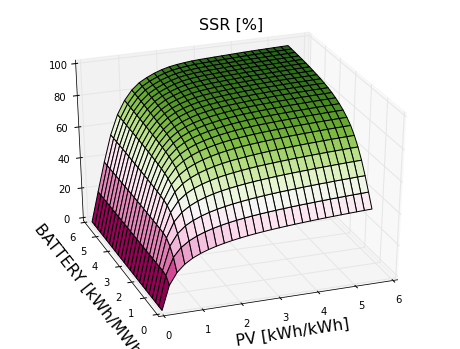

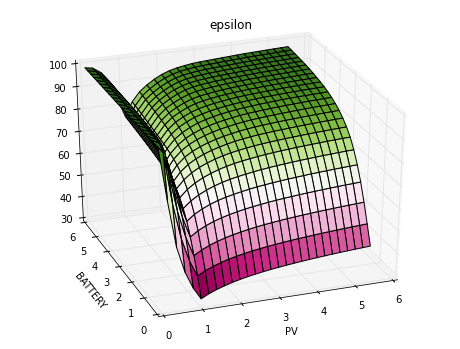

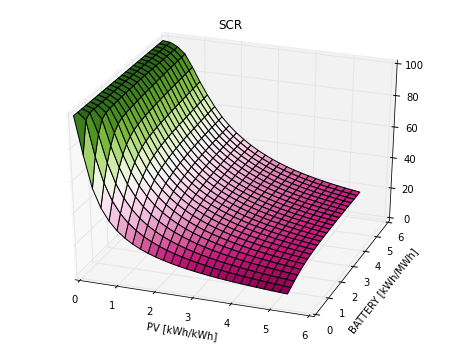

In [18]:
%matplotlib inline

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(30,-110)
#ax.plot_surface(np.log(PV+1),np.log(BAT+1),SSR,cmap=cmaps[32],rstride=1, cstride=1)
ax.plot_surface(PV_hr,BAT_hr,SSR_hr,cmap=cmaps[32],rstride=1, cstride=1)
ax.set_xlabel('PV [kWh/kWh]')
ax.xaxis.label.set_fontsize(16)
ax.set_ylabel('BATTERY [kWh/MWh]')
ax.yaxis.label.set_fontsize(16)
plt.title('SSR [%]',fontsize=16)


fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(30,-110)
#ax.plot_surface(np.log(PV+1),np.log(BAT+1),SSR,cmap=cmaps[32],rstride=1, cstride=1)
ax.plot_surface(PV_hr,BAT_hr,epsilon,cmap=cmaps[32],rstride=1, cstride=1)
ax.set_xlabel('PV')
ax.set_ylabel('BATTERY')
plt.title('epsilon')


fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(30,-70)
#ax.plot_surface(np.log(PV+1),np.log(BAT+1),SSR,cmap=cmaps[32],rstride=1, cstride=1)
ax.plot_surface(PV_hr,BAT_hr,SCR_hr,cmap=cmaps[32],rstride=1, cstride=1)
ax.set_xlabel('PV [kWh/kWh]')
ax.set_ylabel('BATTERY [kWh/MWh]')
plt.title('SCR')




In [20]:
with open('pickle/SSR_hr.pickle','wb') as f:
    pickle.dump([PV_hr, BAT_hr, SSR_hr],f, protocol=pickle.HIGHEST_PROTOCOL)
pickle.dump([PV_hr, BAT_hr, SSR_hr],open('pickle/SSR_hr2.pickle','wb'))
SSR_pd = pd.DataFrame(SSR_hr,index=['PV = '+str(PV_hr[i,0]) for i in range(PV_hr.shape[0])], \
                      columns = ['Bat = '+str(BAT_hr[i,0]) for i in range(BAT_hr.shape[1])])
SSR_pd.to_excel('outputs/SSR_values.xlsx')

### Contour plots

/usr/lib/python2.7/dist-packages/matplotlib/collections.py:631: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


/usr/lib/python2.7/dist-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/usr/lib/python2.7/dist-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


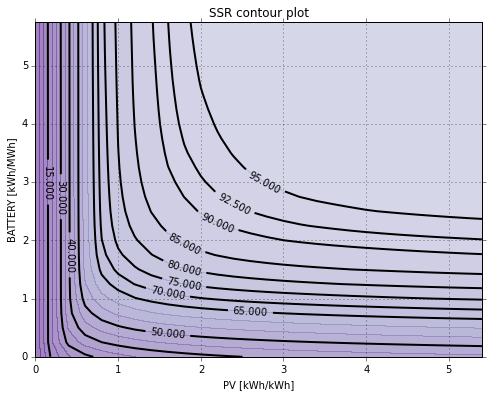

In [27]:
import matplotlib
import matplotlib.cm as cm
import matplotlib.mlab as mlab

matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

# Create a simple contour plot with labels using default colors.  The
# inline argument to clabel will control whether the labels are draw
# over the line segments of the contour, removing the lines beneath
# the label
manual_locations = [(0.5,0.5), (1, 1), (2, 2), 
                    (3, 3), (4, 4), (5, 5)]
plt.figure(figsize=(8, 6))
levels = [0,15,30,40,50,65,70,75,80,85,90,92.5,95]
CS = plt.contour(PV_hr, BAT_hr, SSR_hr, colors='black', linewidths=2. ,levels=levels)
CS2 = plt.contourf(PV_hr, BAT_hr, SSR_hr, cmap=cm.Purples_r, alpha=0.5,levels=np.linspace(0,170,35))
plt.grid()
plt.clabel(CS, inline=1, fontsize=10)
plt.title('SSR contour plot')
plt.xlabel('PV [kWh/kWh]')
plt.ylabel('BATTERY [kWh/MWh]')